### 导入库和数据

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [62]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")


### 查看训练集和训练集信息

In [63]:
train_df.head()

id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission                                accident  \
0                             A/T                           None reported   
1                             A/T  At least 1 accident or damage reported   
2                             A/T                           None reported   
3  Transmission w/Dual Shift Mode                           None reported   
4                     7-Speed A/T                           None reported   

  clean_title  price  
0         Yes   4200  
1         Yes   4999  
2         Yes  13900  
3         Yes  45000  
4         Yes  97500

In [64]:
# 打印训练集相关信息
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   accident      186081 non-null  object
 9   clean_title   167114 non-null  object
 10  price         188533 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 15.8+ MB


In [65]:
# 打印测试集相关信息
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   accident      124058 non-null  object
 9   clean_title   111451 non-null  object
dtypes: int64(3), object(7)
memory usage: 9.6+ MB


### 数据预处理

#### 重复值

In [66]:
# 查看重复值
print(f'训练集重复值：{train_df.duplicated().sum()}')
print(f'测试集重复值：{test_df.duplicated().sum()}')

训练集重复值：0
测试集重复值：0


#### 缺失值

In [67]:
# 查看缺失值
print('训练集缺失值:')
print(train_df.isnull().sum())
print('-' * 50)
print('测试集缺失值:')
print(test_df.isnull().sum())

训练集缺失值:
id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
accident         2452
clean_title     21419
price               0
dtype: int64
--------------------------------------------------
测试集缺失值:
id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
accident         1632
clean_title     14239
dtype: int64


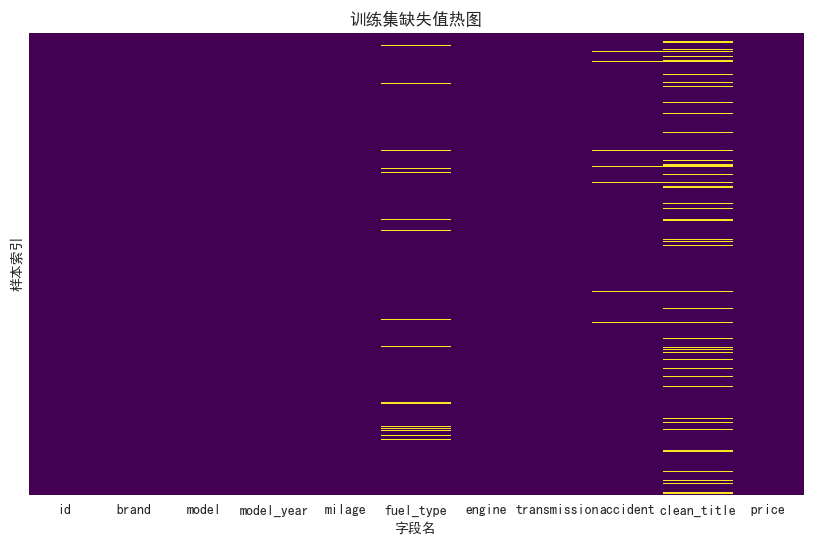

In [68]:
plt.figure(figsize=(10, 6))
# 绘制热图显示缺失值的分布
plt.rcParams['font.family'] = 'SimHei'
sns.heatmap(train_df.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('训练集缺失值热图')
plt.xlabel('字段名')
plt.ylabel('样本索引')
plt.show()

##### fuel_type燃料类型缺失值

In [69]:
# 处理字段fuel_type燃料类型缺失值：按品牌和型号填充，若无法确定则使用品牌的众数
# 首先将 '–' 标记为缺失值
train_df['fuel_type'] = train_df['fuel_type'].replace('–', np.nan)
test_df['fuel_type'] = test_df['fuel_type'].replace('–', np.nan)
# 处理燃料类型缺失值：按品牌和型号填充，若无法确定则使用品牌的众数
fuel_type_mode_by_brand_model = train_df.groupby(['brand', 'model'])['fuel_type'].apply(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None)
fuel_type_mode_by_brand = train_df.groupby('brand')['fuel_type'].apply(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None)


def fill_fuel_type(row):
    if pd.isnull(row['fuel_type']):
        # 先按品牌和型号填充
        brand_model_fill = fuel_type_mode_by_brand_model.get((row['brand'], row['model']), None)
        # 若品牌和型号均缺失，按品牌填充
        return brand_model_fill if brand_model_fill is not None else fuel_type_mode_by_brand.get(row['brand'],
                                                                                                 'Gasoline')
    return row['fuel_type']


# 应用填充方法到训练集和测试集
train_df['fuel_type'] = train_df.apply(fill_fuel_type, axis=1)
test_df['fuel_type'] = test_df.apply(fill_fuel_type, axis=1)

##### accident处理事故历史缺失值

In [70]:
# 处理事故历史缺失值：删除有缺失值的行
train_df.dropna(subset=['accident'], inplace=True)
test_df.dropna(subset=['accident'], inplace=True)

##### clean_title是否拥有健全良好的所有权证明缺失值

In [71]:
# 删除训练集和测试集中的 clean_title 列
train_df.drop(columns=['clean_title'], inplace=True)
test_df.drop(columns=['clean_title'], inplace=True)

In [72]:
# 重新查看缺失值
print('处理后训练集缺失值:')
print(train_df.isnull().sum())
print('-' * 50)
print('处理后测试集缺失值:')
print(test_df.isnull().sum())

处理后训练集缺失值:
id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
accident        0
price           0
dtype: int64
--------------------------------------------------
处理后测试集缺失值:
id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
accident        0
dtype: int64


##### 处理字段engine排量信息

In [73]:
# 定义函数，用于提取符合 "X.XL" 格式的排量信息
def extract_displacement(engine_info):
    # 匹配标准格式的排量
    match = re.search(r'(\d+\.\d+)L', str(engine_info))
    if match:
        # 提取数值部分并转化为浮点数
        return float(match.group(1))
        # 若没有匹配到排量信息，则返回 None
    return None


# 应用函数提取排量信息，生成新的 'displacement' 列
train_df['displacement'] = train_df['engine'].apply(extract_displacement)
test_df['displacement'] = test_df['engine'].apply(extract_displacement)

In [74]:
# 统计训练集和测试集中 'displacement' 列的缺失值数量
print(f'训练集displacement缺失值:{train_df['displacement'].isnull().sum()}')
print(f'测试集displacement缺失值:{test_df['displacement'].isnull().sum()}')

训练集displacement缺失值:14078
测试集displacement缺失值:9334


In [75]:
# 删除displacement缺失值
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [76]:
# 重新查看训练集和测试集中 'displacement' 列的缺失值数量
print(f'训练集displacement缺失值:{train_df['displacement'].isnull().sum()}')
print(f'测试集displacement缺失值:{test_df['displacement'].isnull().sum()}')

训练集displacement缺失值:0
测试集displacement缺失值:0


In [77]:
# 定义函数，根据排量划分等级
def categorize_displacement(displacement):
    # 对电动车直接返回 Electric
    if displacement == "Electric":
        return "Electric"
    # 判断数值的区间，并返回相应的类别
    elif displacement <= 1.0:
        return "Small"
    elif 1.0 < displacement <= 1.6:
        return "Medium"
    elif 1.6 < displacement <= 2.5:
        return "Large"
    elif 2.5 < displacement <= 4.0:
        return "Extra-large"
    else:
        return "Ultra-large"


# 应用划分函数到训练集和测试集
train_df['displacement'] = train_df['displacement'].apply(categorize_displacement)
test_df['displacement'] = test_df['displacement'].apply(categorize_displacement)

In [78]:
# 删除原来训练集和测试集中的 engine 列
train_df.drop(columns=['engine'], inplace=True)
test_df.drop(columns=['engine'], inplace=True)

##### 处理字段transmission变速器类型

In [79]:
# 定义函数，将变速器类型分为 'Automatic'、'Manual' 和 'Other'
def categorize_transmission(transmission):
    transmission = str(transmission).lower()
    if any(keyword in transmission for keyword in ["automatic", "a/t", "cvt", "speed"]):
        return "Automatic"
    elif any(keyword in transmission for keyword in ["manual", "m/t"]):
        return "Manual"
    else:
        return "Other"


# 应用函数到训练集和测试集
train_df['transmission'] = train_df['transmission'].apply(categorize_transmission)
test_df['transmission'] = test_df['transmission'].apply(categorize_transmission)

In [80]:
train_df.head()

id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

  transmission                                accident  price displacement  
0    Automatic                           None reported   4200       Medium  
1    Automatic  At least 1 accident or damage reported   4999  Extra-large  
2    Automatic                           None reported  13900  Ultra-large  
3        Other                           None reported  45000  Ultra-large  
4    Automatic                           None reported  97500        Large

### 数据可视化分析

In [81]:
train_data = train_df
# 避免log(0)的问题
train_data['log_price'] = np.log1p(train_data['price'])

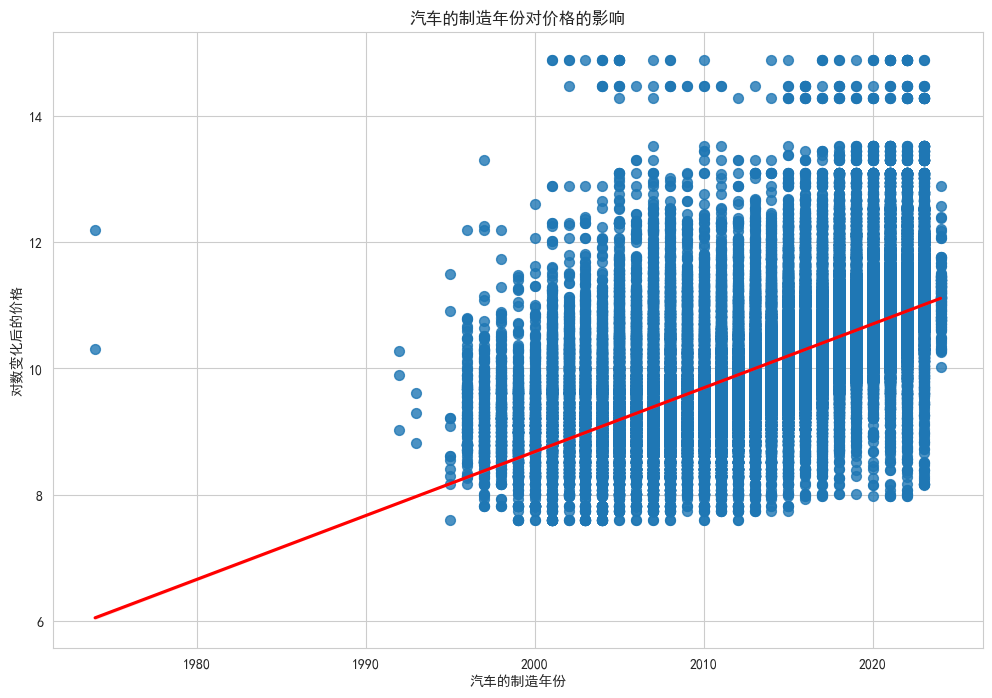

In [82]:
# 绘制汽车的制造年份与价格的关系图
plt.figure(figsize=(12, 8))
sns.regplot(x='model_year', y='log_price', data=train_data,
            scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title("汽车的制造年份对价格的影响")
plt.xlabel("汽车的制造年份")
plt.ylabel("对数变化后的价格")
plt.show()

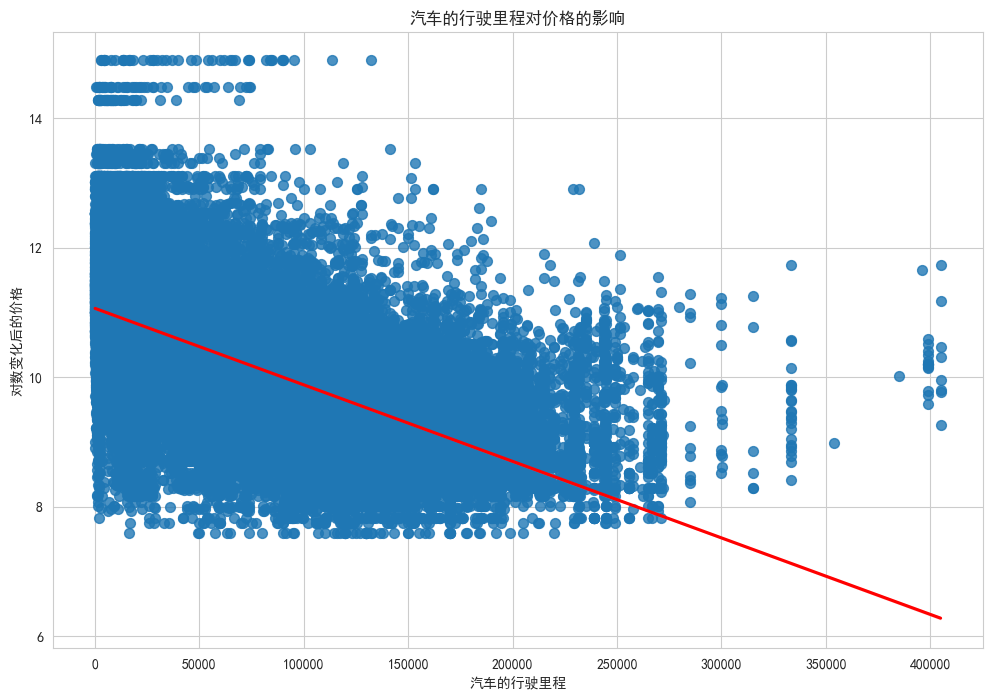

In [83]:
# 绘制汽车的行驶里程与价格的关系图
plt.figure(figsize=(12, 8))
sns.regplot(x='milage', y='log_price', data=train_data,
            scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title("汽车的行驶里程对价格的影响")
plt.xlabel("汽车的行驶里程")
plt.ylabel("对数变化后的价格")
plt.show()

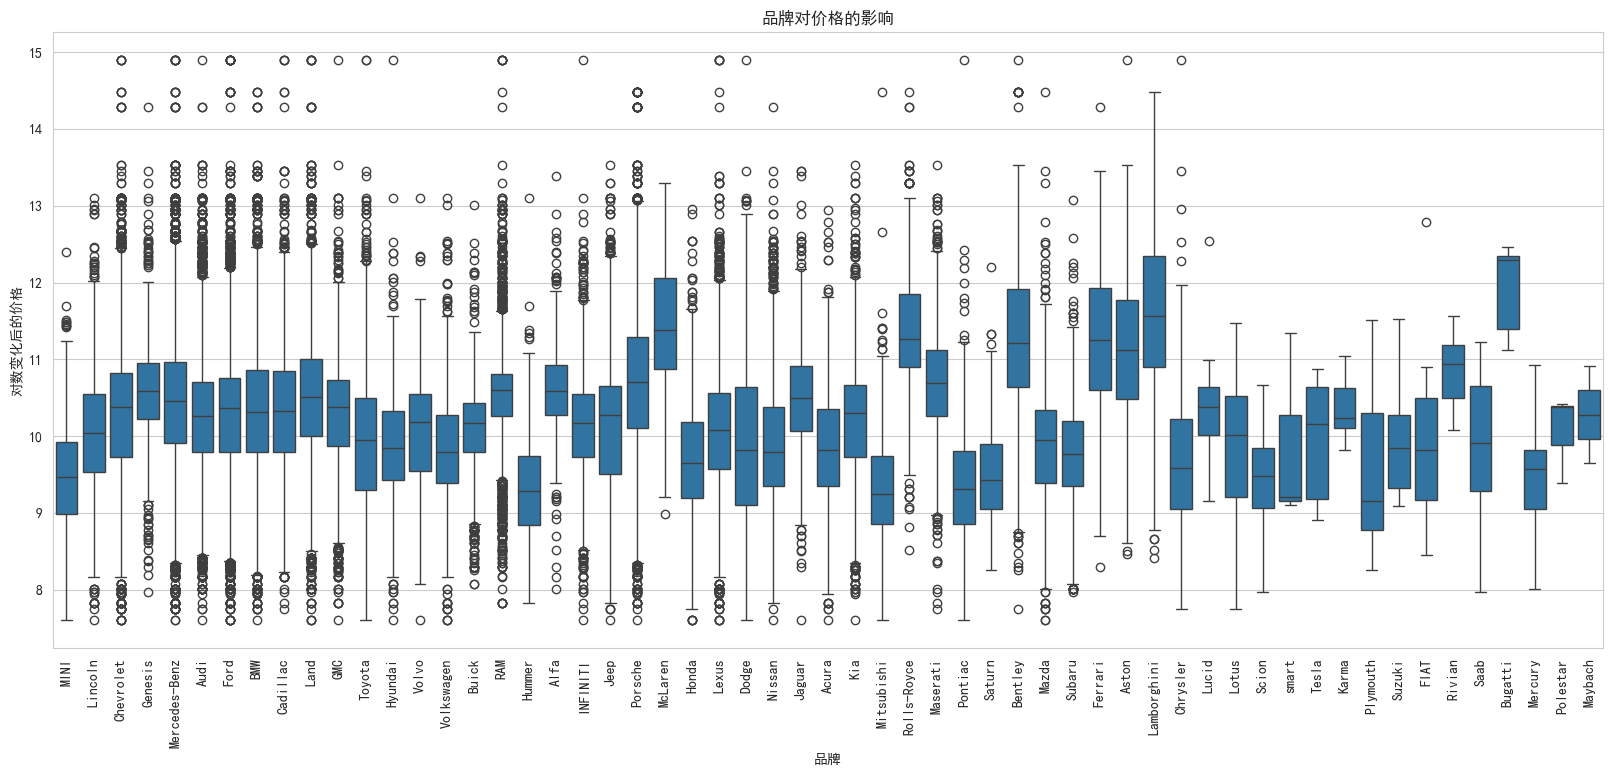

In [84]:
# 品牌对价格的影响
plt.figure(figsize=(20, 8))
sns.boxplot(data=train_data, x='brand', y='log_price')
plt.title("品牌对价格的影响")
plt.xticks(rotation=90)
plt.xlabel("品牌")
plt.ylabel("对数变化后的价格")
plt.show()

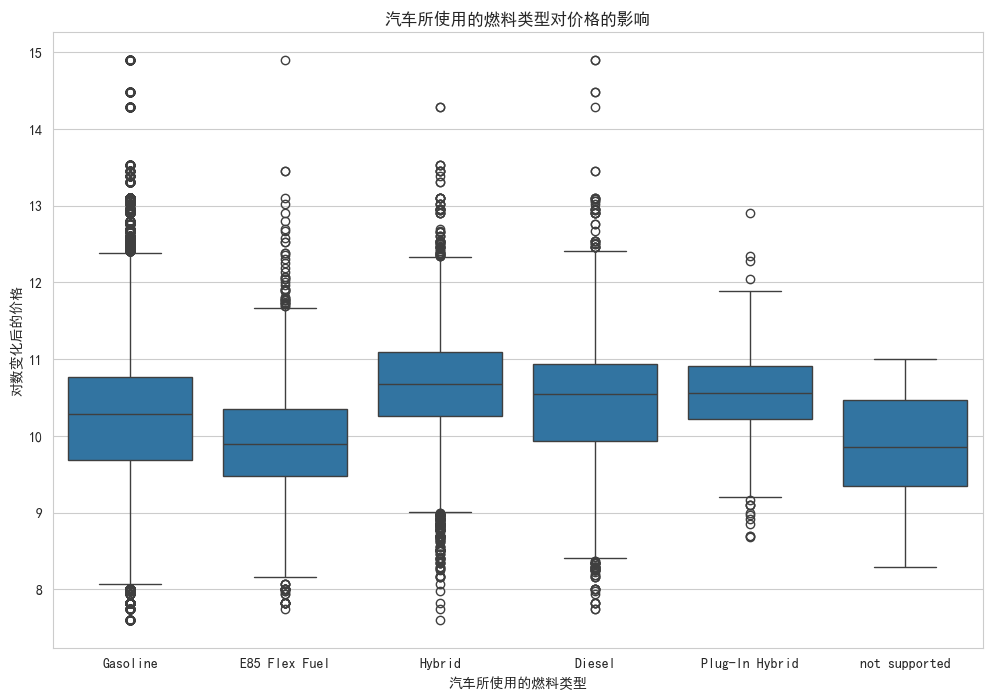

In [85]:
# 绘制汽车所使用的燃料类型和价格的关系图
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_data, x='fuel_type', y='log_price')
plt.title('汽车所使用的燃料类型对价格的影响')
plt.xlabel('汽车所使用的燃料类型')
plt.ylabel('对数变化后的价格')
plt.show()

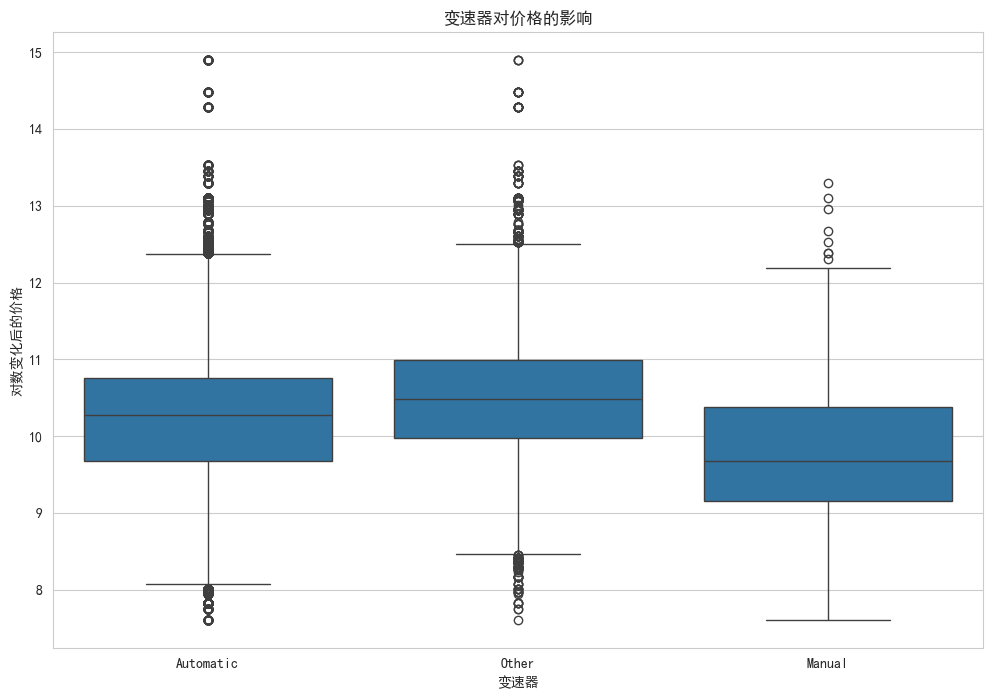

In [86]:
# 绘制变速器和价格的关系图
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_data, x='transmission', y='log_price')
plt.title("变速器对价格的影响")
plt.xlabel("变速器")
plt.ylabel("对数变化后的价格")
plt.show()

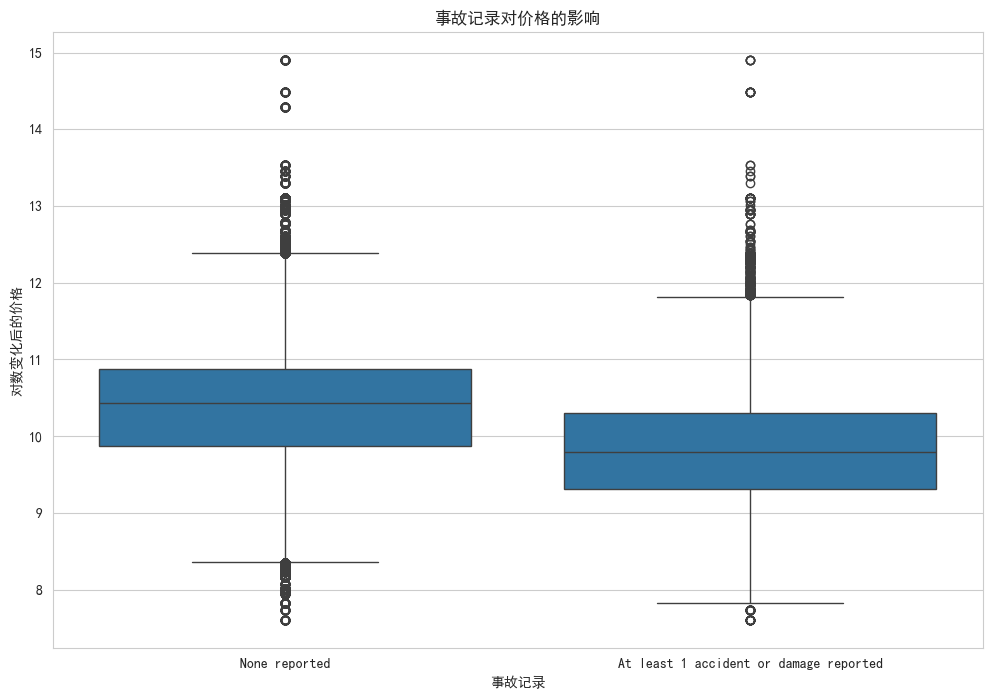

In [87]:
# 绘制事故记录和价格的关系图
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_data, x='accident', y='log_price')
plt.title("事故记录对价格的影响")
plt.xlabel("事故记录")
plt.ylabel("对数变化后的价格")
plt.show()

### 创建模型

#### 数据预处理

In [88]:
model_train_data = train_df.copy()
model_test_data = test_df.copy()

In [89]:
# 增加新特征 车龄current_year  
current_year = datetime.now().year
model_train_data['car_age'] = current_year - model_train_data['model_year']
model_test_data['car_age'] = current_year - model_test_data['model_year']
# 删除原来的生产列model_year
model_train_data.drop('model_year', inplace=True, axis=1)
model_test_data.drop('model_year', inplace=True, axis=1)
# 删除 dataset列
# model_train_data.drop('dataset', inplace=True, axis=1)
# model_test_data.drop('dataset', inplace=True, axis=1)
model_train_data

id          brand                     model  milage  \
0            0           MINI             Cooper S Base  213000   
1            1        Lincoln                     LS V8  143250   
2            2      Chevrolet         Silverado 2500 LT  136731   
3            3        Genesis          G90 5.0 Ultimate   19500   
4            4  Mercedes-Benz               Metris Base    7388   
...        ...            ...                       ...     ...   
188528  188528       Cadillac     Escalade ESV Platinum   49000   
188529  188529  Mercedes-Benz  AMG C 43 AMG C 43 4MATIC   28600   
188530  188530  Mercedes-Benz    AMG GLC 63 Base 4MATIC   13650   
188531  188531           Audi          S5 3.0T Prestige   13895   
188532  188532        Porsche                Macan Base   59500   

            fuel_type transmission                                accident  \
0            Gasoline    Automatic                           None reported   
1            Gasoline    Automatic  At least 1 accident or damage reported   
2       E85 Flex Fuel    Automatic                           None reported   
3            Gasoline        Other                           None reported   
4            Gasoline    Automatic                           None reported   
...               ...          ...                                     ...   
188528       Gasoline        Other                           None reported   
188529       Gasoline    Automatic  At least 1 accident or damage reported   
188530       Gasoline    Automatic                           None reported   
188531       Gasoline    Automatic                           None reported   
188532       Gasoline        Other                           None reported   

        price displacement  log_price  car_age  
0        4200       Medium   8.343078       17  
1        4999  Extra-large   8.517193       22  
2       13900  Ultra-large   9.539716       22  
3       45000  Ultra-large  10.714440        7  
4       97500        Large  11.487618        3  
...       ...          ...        ...      ...  
188528  27500  Ultra-large  10.221978        7  
188529  30000  Extra-large  10.308986        6  
188530  86900  Extra-large  11.372525        3  
188531  84900  Extra-large  11.349241        2  
188532  28995        Large  10.274913        8  

[172003 rows x 11 columns]

In [90]:
# 定义需要编码的类别特征
categorical_features = model_train_data.select_dtypes(include=['object']).columns.tolist()

# 创建一个字典来保存每个特征的 LabelEncoder
label_encoders = {}
# 对 new_train_data 进行编码并保存编码器
for col in categorical_features:
    le = LabelEncoder()
    col1 = col + '_LE'
    model_train_data[col1] = le.fit_transform(model_train_data[col].astype(str))
    label_encoders[col] = le  # 保存编码器，供测试数据使用

# 使用相同的编码器对 new_test_data 进行编码
for col in categorical_features:
    if col in model_test_data.columns:  # 确保测试数据包含该列
        col1 = col + '_LE'
        le = label_encoders[col]
        # 处理测试数据中出现的新类别（即训练数据中没有见过的类别）
        model_test_data[col1] = model_test_data[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)

In [91]:
model_train_data

id          brand                     model  milage  \
0            0           MINI             Cooper S Base  213000   
1            1        Lincoln                     LS V8  143250   
2            2      Chevrolet         Silverado 2500 LT  136731   
3            3        Genesis          G90 5.0 Ultimate   19500   
4            4  Mercedes-Benz               Metris Base    7388   
...        ...            ...                       ...     ...   
188528  188528       Cadillac     Escalade ESV Platinum   49000   
188529  188529  Mercedes-Benz  AMG C 43 AMG C 43 4MATIC   28600   
188530  188530  Mercedes-Benz    AMG GLC 63 Base 4MATIC   13650   
188531  188531           Audi          S5 3.0T Prestige   13895   
188532  188532        Porsche                Macan Base   59500   

            fuel_type transmission                                accident  \
0            Gasoline    Automatic                           None reported   
1            Gasoline    Automatic  At least 1 accident or damage reported   
2       E85 Flex Fuel    Automatic                           None reported   
3            Gasoline        Other                           None reported   
4            Gasoline    Automatic                           None reported   
...               ...          ...                                     ...   
188528       Gasoline        Other                           None reported   
188529       Gasoline    Automatic  At least 1 accident or damage reported   
188530       Gasoline    Automatic                           None reported   
188531       Gasoline    Automatic                           None reported   
188532       Gasoline        Other                           None reported   

        price displacement  log_price  car_age  brand_LE  model_LE  \
0        4200       Medium   8.343078       17        31       492   
1        4999  Extra-large   8.517193       22        28       922   
2       13900  Ultra-large   9.539716       22         9      1543   
3       45000  Ultra-large  10.714440        7        16       753   
4       97500        Large  11.487618        3        36      1068   
...       ...          ...        ...      ...       ...       ...   
188528  27500  Ultra-large  10.221978        7         8       599   
188529  30000  Extra-large  10.308986        6        36       205   
188530  86900  Extra-large  11.372525        3        36       222   
188531  84900  Extra-large  11.349241        2         3      1439   
188532  28995        Large  10.274913        8        43      1019   

        fuel_type_LE  transmission_LE  accident_LE  displacement_LE  
0                  2                0            1                2  
1                  2                0            0                0  
2                  1                0            1                4  
3                  2                2            1                4  
4                  2                0            1                1  
...              ...              ...          ...              ...  
188528             2                2            1                4  
188529             2                0            0                0  
188530             2                0            1                0  
188531             2                0            1                0  
188532             2                2            1                1  

[172003 rows x 17 columns]

In [92]:
from sklearn.preprocessing import StandardScaler

# 特征标准化
# 数值型特征（车龄和对数化的里程数）
numerical_features = ['car_age', 'milage']
# 对数值型特征进行标准化
scaler = StandardScaler()
model_train_data[numerical_features] = scaler.fit_transform(model_train_data[numerical_features])
model_train_data[numerical_features] = scaler.transform(model_train_data[numerical_features])

In [93]:
x = model_train_data[['car_age', 'brand_LE', 'model_LE',
                      'fuel_type_LE', 'transmission_LE', 'accident_LE', 'displacement_LE']]
y = model_train_data['price']
# 分割数据
x_train, x_test, y_train, y_test,= train_test_split(x, y,est_size=0.2, random_state=15)

In [94]:
# 网格搜索法
# 定义参数网格
param_grid = {
    'n_estimators': [5, 10, 50, 100, 200],  # 决策树的数量
    'max_depth': [None, 10, 15, 20],  # 树的最大深度
    'min_samples_split': [2, 5, 10]  # 节点划分最少样本数
}

# 初始化随机森林回归器
rf_model = RandomForestRegressor(random_state=15, n_jobs=-1)
# 初始化网格搜索
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
# 执行网格搜索
grid_search.fit(x_train, y_train)
# 输出最佳参数
print("最佳参数:", grid_search.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
最佳参数: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}


In [95]:
rf_model = RandomForestRegressor(random_state=15, n_jobs=-1,
                                     max_depth=15, min_samples_split=10, n_estimators=200)
rf_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_split=10, n_estimators=200,
                      n_jobs=-1, random_state=15)

In [96]:
y_pred = rf_model.predict(x_test)

# 计算对数域中的性能指标
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n对数域中的性能:")
print(f"MSE : {mse:.5f}")
print(f"MAE : {mae:.5f}")
print(f"RMSE : {rmse:.5f}")
print(f"R2 Score : {r2:.5f}")


对数域中的性能:
MSE (log): 0.29056
MAE (log): 0.38142
RMSE (log): 0.53904
R2 Score (log): 0.59243


In [97]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

In [98]:
alpha_range = np.logspace(-3, 3, 10)
ridge_cv = RidgeCV(alphas=alpha_range, scoring='r2', cv=5)  # 5折交叉验证
# 对原始价格进行训练
ridge_cv.fit(x_train, y_train)
# 输出最佳alpha值
best_alpha = ridge_cv.alpha_
print("最佳 alpha:", best_alpha)

最佳 alpha: 0.46415888336127775


In [99]:
# 使用最佳 alpha 创建 Ridge 模型
ridge_model_original = Ridge(alpha=best_alpha, random_state=15)
ridge_model_original.fit(x_train, y_train)

Ridge(alpha=np.float64(0.46415888336127775), random_state=15)

In [100]:
y_pred = ridge_model_original.predict(x_test)
mse = mean_squared_error(y_test, y)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n对数域中的性能:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")


对数域中的性能:
MSE: 4691679752.80
MAE: 24242.51
RMSE: 68495.84
R2 Score: 0.0752


In [101]:
x_test_new = model_test_data[
    ['car_age', 'brand_LE', 'model_LE', 'fuel_type_LE', 'transmission_LE', 'accident_LE', 'displacement_LE']]
# 使用模型预测对数价格
y_pred_new = rf_model.predict(x_test_new)
# 将预测的对数价格转换回原始价格
y_pred_new = np.exp(y_pred_new)
y_pred_new = np.round(y_pred_new).astype(int)
# 将预测结果添加到原始数据框中
test_df['rf_predicted_price'] = y_pred_new
test_df.head()

id      brand                  model  model_year  milage fuel_type  \
0  188533       Land         Rover LR2 Base        2015   98000  Gasoline   
1  188534       Land      Rover Defender SE        2020    9142    Hybrid   
2  188535       Ford     Expedition Limited        2022   28121  Gasoline   
4  188537       Audi   A6 2.0T Premium Plus        2018   59000  Gasoline   
5  188538  Chevrolet  Express 2500 Work Van        2013   99524  Gasoline   

  transmission       accident displacement  rf_predicted_price  
0    Automatic  None reported        Large               10685  
1    Automatic  None reported  Extra-large               10020  
2    Automatic  None reported  Extra-large                7580  
4    Automatic  None reported        Large                9811  
5    Automatic  None reported  Ultra-large               50647